In [ ]:
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import seaborn as sns
import torch.nn.functional as F

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

#classes: {Deer, Horse, Truck}= {4, 7, 9}
selected_classes = [4, 7, 9]

def filter_classes(dataset, classes, samples_per_class):
    class_counts = {cls: 0 for cls in classes}
    indices = []
    for i, (_, label) in enumerate(dataset):
        if label in classes and class_counts[label] < samples_per_class:
            indices.append(i)
            class_counts[label] += 1
        if all(count >= samples_per_class for count in class_counts.values()):
            break
    return Subset(dataset, indices)

train_data = filter_classes(train_data, selected_classes, 6000)
test_data = filter_classes(test_data, selected_classes, 1000)

class_map = {cls: i for i, cls in enumerate(selected_classes)}

def remap_labels(dataset, class_map):
    for i in range(len(dataset)):
        dataset.dataset.targets[dataset.indices[i]] = class_map[dataset.dataset.targets[dataset.indices[i]]]

remap_labels(train_data, class_map)
remap_labels(test_data, class_map)

train_indices = [train_data.dataset.targets[i] for i in train_data.indices]
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(train_indices)), train_indices))

train_dataset = Subset(train_data, train_idx)
val_dataset = Subset(train_data, val_idx)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_data)}")


Files already downloaded and verified
Files already downloaded and verified
Train dataset size: 12000
Validation dataset size: 3000
Test dataset size: 3000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.9607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.79607844].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0

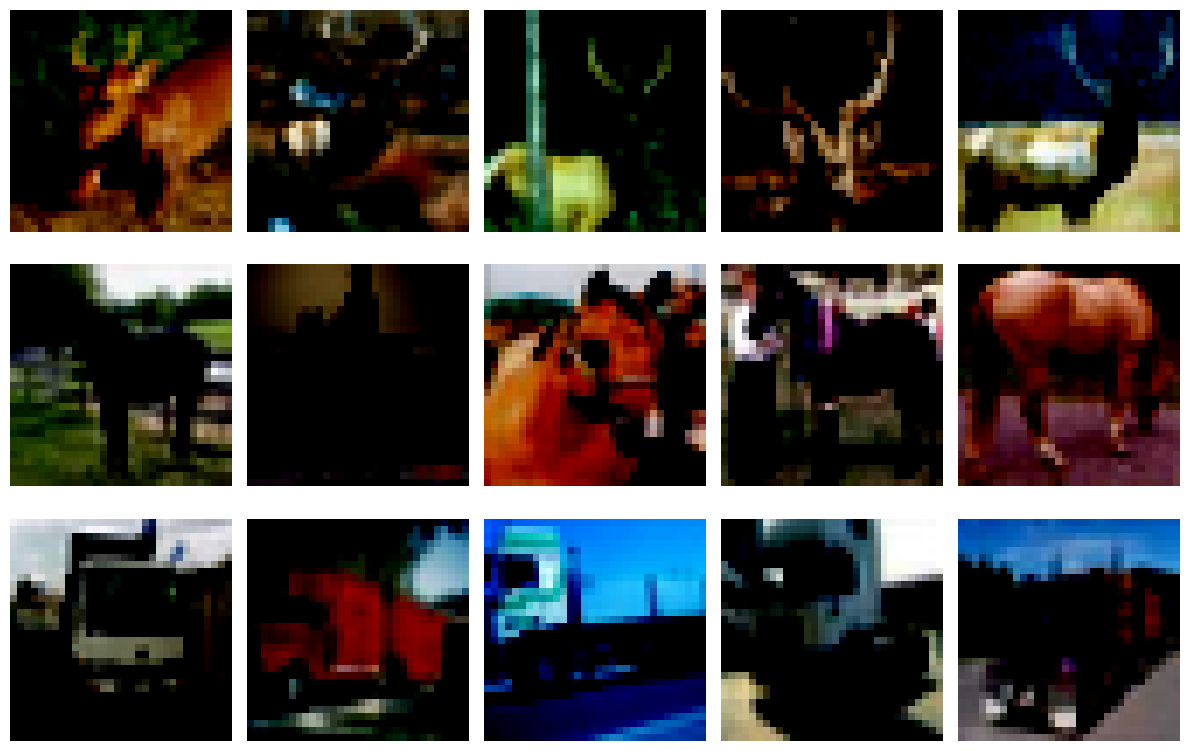

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99215686..0.96862745].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..0.9843137].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..0.94509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8117647..0.8509804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9

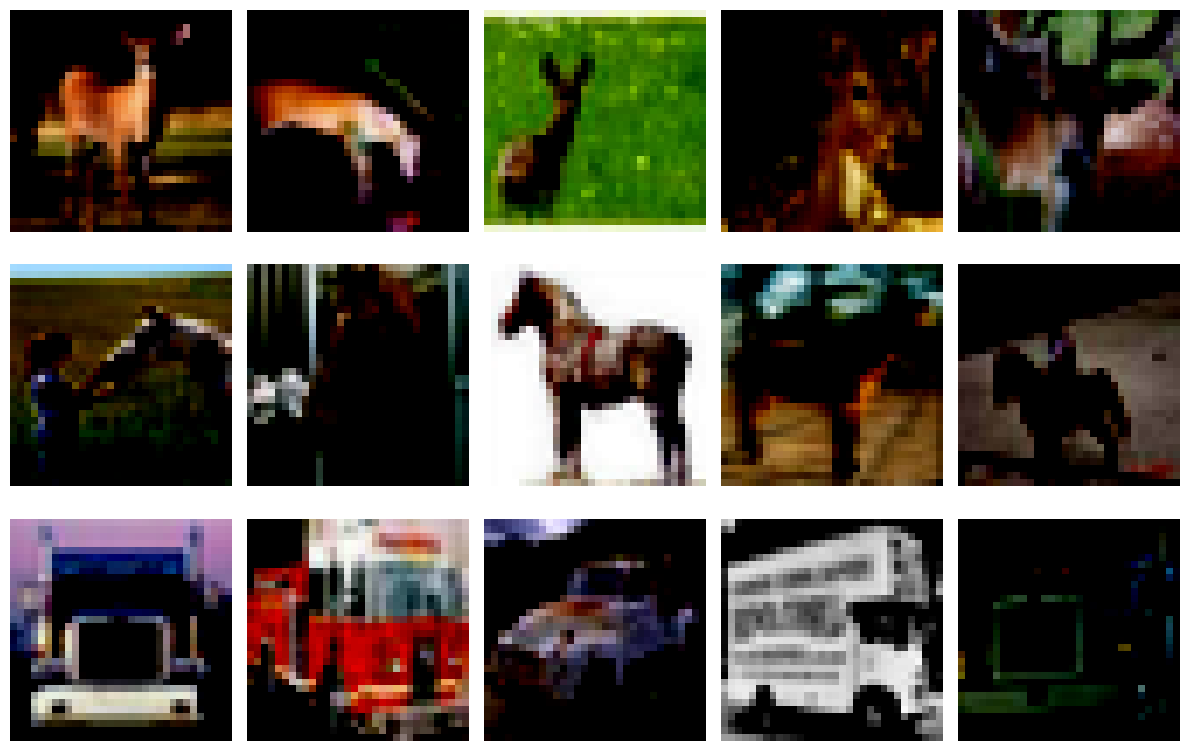

In [ ]:

def visualize_images(loader, classes, num_images=5):
    data_iter = iter(loader)
    
    images, labels = next(data_iter)
    
    images, labels = images.numpy(), labels.numpy()
    
    fig, axes = plt.subplots(len(classes), num_images, figsize=(12, 8))
    for i, cls in enumerate(classes):

        cls_indices = np.where(labels == i)[0]
        

        if len(cls_indices) < num_images:
            print(f"Not enough images for class {cls}")
            continue
        

        cls_images = images[cls_indices][:num_images]
        for j in range(num_images):

            axes[i, j].imshow(np.transpose(cls_images[j], (1, 2, 0)))
            axes[i, j].axis('off')
        

        axes[i, 0].set_ylabel(f"Class {cls}", fontsize=12)
    
    plt.tight_layout()
    plt.show()


visualize_images(train_loader, selected_classes)
visualize_images(val_loader, selected_classes)



In [20]:
#CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=3)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, 16)
        self.fc2 = nn.Linear(16, 3)

    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


model = CNN()


In [ ]:
from torch.optim import Adam
from sklearn.metrics import accuracy_score

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    train_losses.append(total_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)
    
    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

# Save model
torch.save(model.state_dict(), "cnn_model.pth")


Epoch 1/15: Train Loss: 0.7113, Train Acc: 0.6788, Val Loss: 0.5724, Val Acc: 0.7563
Epoch 2/15: Train Loss: 0.5445, Train Acc: 0.7710, Val Loss: 0.5340, Val Acc: 0.7783
Epoch 3/15: Train Loss: 0.4814, Train Acc: 0.7987, Val Loss: 0.4758, Val Acc: 0.8070
Epoch 4/15: Train Loss: 0.4371, Train Acc: 0.8203, Val Loss: 0.4481, Val Acc: 0.8210
Epoch 5/15: Train Loss: 0.4039, Train Acc: 0.8369, Val Loss: 0.4187, Val Acc: 0.8317
Epoch 6/15: Train Loss: 0.3774, Train Acc: 0.8466, Val Loss: 0.3991, Val Acc: 0.8413
Epoch 7/15: Train Loss: 0.3503, Train Acc: 0.8577, Val Loss: 0.4192, Val Acc: 0.8387
Epoch 8/15: Train Loss: 0.3348, Train Acc: 0.8646, Val Loss: 0.3957, Val Acc: 0.8377
Epoch 9/15: Train Loss: 0.3179, Train Acc: 0.8717, Val Loss: 0.3506, Val Acc: 0.8583
Epoch 10/15: Train Loss: 0.3074, Train Acc: 0.8788, Val Loss: 0.3824, Val Acc: 0.8527
Epoch 11/15: Train Loss: 0.2851, Train Acc: 0.8888, Val Loss: 0.3282, Val Acc: 0.8730
Epoch 12/15: Train Loss: 0.2711, Train Acc: 0.8923, Val Loss: 0

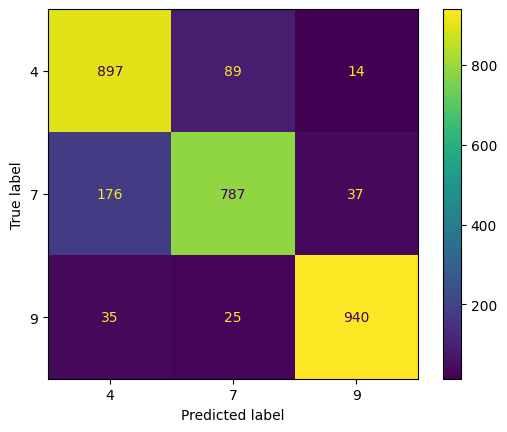

Test Accuracy: 0.8747, Test F1-Score: 0.8744


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

test_preds, test_labels = evaluate_model(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_score = f1_score(test_labels, test_preds, average='weighted')

cm = confusion_matrix(test_labels, test_preds)
ConfusionMatrixDisplay(cm, display_labels=selected_classes).plot()
plt.show()

print(f"Test Accuracy: {test_accuracy:.4f}, Test F1-Score: {test_f1_score:.4f}")


In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = 3 * 32 * 32  
num_classes = 3           
mlp_model = MLP(input_size, num_classes)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)


num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    mlp_model.train()
    train_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:  
        images = images.view(images.size(0), -1)  
        optimizer.zero_grad()
        outputs = mlp_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)
    
    mlp_model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:  
            images = images.view(images.size(0), -1)  
            outputs = mlp_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_correct / val_total)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, "
          f"Val Accuracy: {val_accuracies[-1]:.4f}")

# Save the trained model
torch.save(mlp_model.state_dict(), "mlp_model.pth")


Epoch 1/15, Train Loss: 0.7060, Train Accuracy: 0.6924, Val Loss: 0.6437, Val Accuracy: 0.7337
Epoch 2/15, Train Loss: 0.5810, Train Accuracy: 0.7578, Val Loss: 0.5869, Val Accuracy: 0.7550
Epoch 3/15, Train Loss: 0.5235, Train Accuracy: 0.7863, Val Loss: 0.5738, Val Accuracy: 0.7583
Epoch 4/15, Train Loss: 0.4690, Train Accuracy: 0.8110, Val Loss: 0.5455, Val Accuracy: 0.7767
Epoch 5/15, Train Loss: 0.4303, Train Accuracy: 0.8291, Val Loss: 0.5668, Val Accuracy: 0.7667
Epoch 6/15, Train Loss: 0.3923, Train Accuracy: 0.8458, Val Loss: 0.5761, Val Accuracy: 0.7750
Epoch 7/15, Train Loss: 0.3560, Train Accuracy: 0.8605, Val Loss: 0.6082, Val Accuracy: 0.7630
Epoch 8/15, Train Loss: 0.3273, Train Accuracy: 0.8759, Val Loss: 0.5876, Val Accuracy: 0.7770
Epoch 9/15, Train Loss: 0.2962, Train Accuracy: 0.8863, Val Loss: 0.5905, Val Accuracy: 0.7807
Epoch 10/15, Train Loss: 0.2799, Train Accuracy: 0.8961, Val Loss: 0.6016, Val Accuracy: 0.7807
Epoch 11/15, Train Loss: 0.2524, Train Accuracy: 

Test Accuracy: 0.7847
Test F1-Score: 0.7845


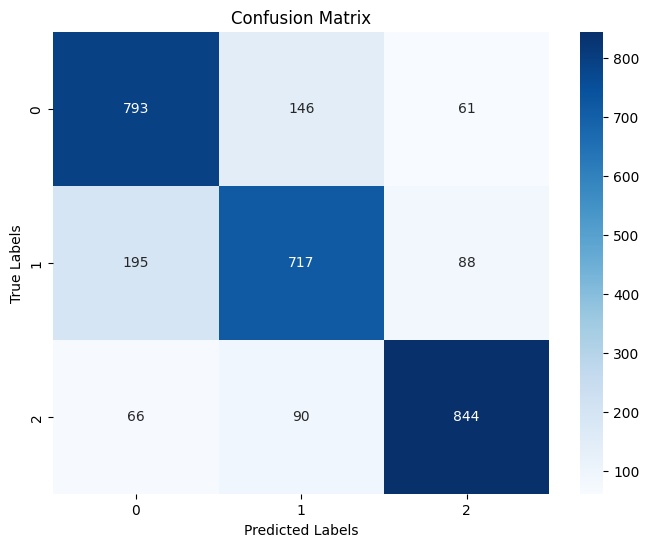

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

mlp_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:  
        images = images.view(images.size(0), -1)  
        outputs = mlp_model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="macro")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


C:\Users\mridu\AppData\Local\Temp\ipykernel_30356\1665088192.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cnn_model.pth"))


Classification Report:
              precision    recall  f1-score   support

        Deer       0.81      0.90      0.85      1000
       Horse       0.87      0.79      0.83      1000
       Truck       0.95      0.94      0.94      1000

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87      3000



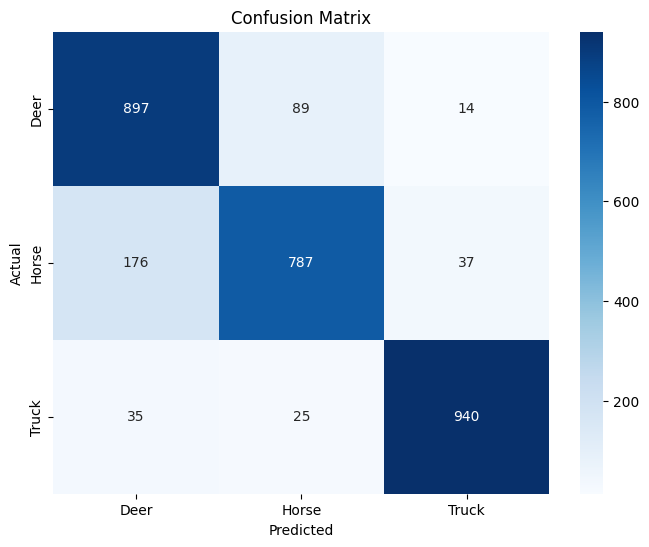

In [ ]:

model = CNN()

model.load_state_dict(torch.load("cnn_model.pth"))
model.eval()  

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)  
        _, predicted = torch.max(outputs, 1)  
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate classification metrics
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["Deer", "Horse", "Truck"]))

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Deer", "Horse", "Truck"],
            yticklabels=["Deer", "Horse", "Truck"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


C:\Users\mridu\AppData\Local\Temp\ipykernel_30356\519316257.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mlp_model.load_state_dict(torch.load("mlp_model.pth"))


Classification Report:
              precision    recall  f1-score   support

        Deer       0.75      0.79      0.77      1000
       Horse       0.75      0.72      0.73      1000
       Truck       0.85      0.84      0.85      1000

    accuracy                           0.78      3000
   macro avg       0.78      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



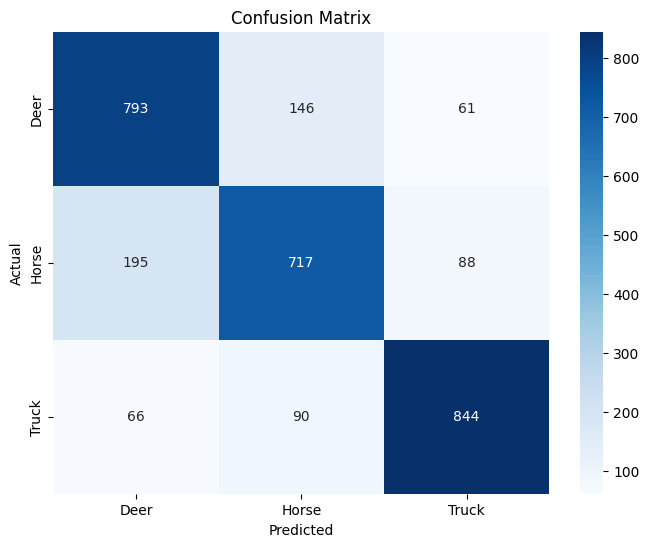

In [ ]:


class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


input_size = 3 * 32 * 32  
hidden_size = 64         
num_classes = 3          

mlp_model = MLP(input_size, hidden_size, num_classes)
mlp_model.load_state_dict(torch.load("mlp_model.pth"))
mlp_model.eval()

test_images, test_labels = [], []

for images, labels in test_loader:
    flattened_images = images.view(images.size(0), -1) 
    test_images.append(flattened_images)
    test_labels.extend(labels.numpy())

test_images = torch.cat(test_images) 
test_labels = np.array(test_labels)

with torch.no_grad():
    outputs = mlp_model(test_images)
    _, test_preds = torch.max(outputs, 1)

print("Classification Report:")
print(classification_report(test_labels, test_preds.numpy(), target_names=["Deer", "Horse", "Truck"]))

conf_matrix = confusion_matrix(test_labels, test_preds.numpy())
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Deer", "Horse", "Truck"],
            yticklabels=["Deer", "Horse", "Truck"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
